In [ ]:
#! pip install Pillow
! pip install pytesseract

     |████████████████████████████████| 3.1 MB 5.0 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

In [ ]:
!pip install mysql-connector-python

In [ ]:
import mysql.connector

In [ ]:
mydb = mysql.connector.connect(
  host="discountmate.ddns.net",
  user="discountmateuser",
  password="DMPassword$",
  database="discountmate")

In [ ]:
if mydb.is_connected:
  print("connected")

connected


In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
import re
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output
from prettytable import PrettyTable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install Pillow==9.0.0

     |████████████████████████████████| 4.3 MB 5.1 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.1.1
    Uninstalling Pillow-9.1.1:
      Successfully uninstalled Pillow-9.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


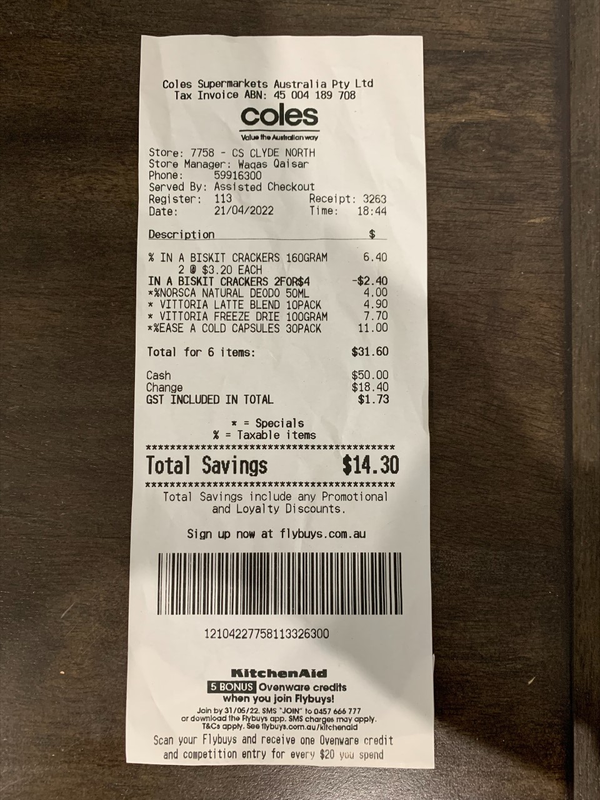

In [ ]:
# Sample file out of the dataset
file_name = '/content/drive/MyDrive/OCR/coles.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [ ]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [ ]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [ ]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

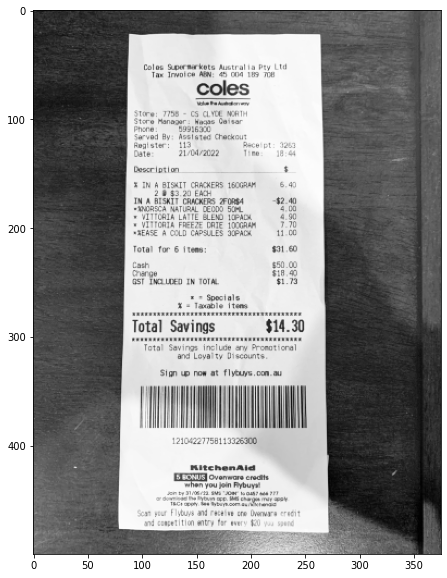

In [ ]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

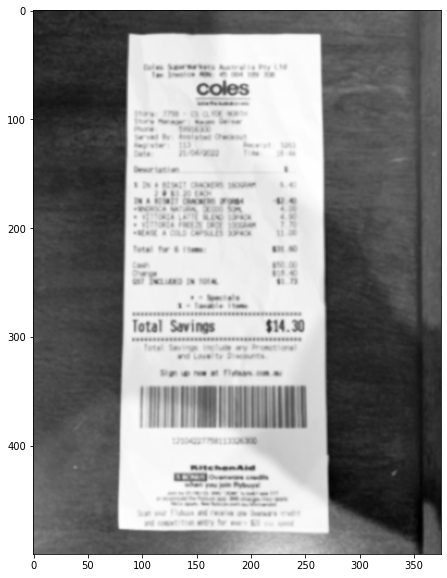

In [ ]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

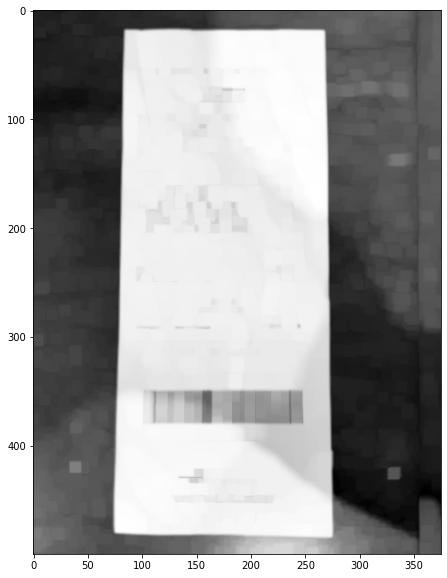

In [ ]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

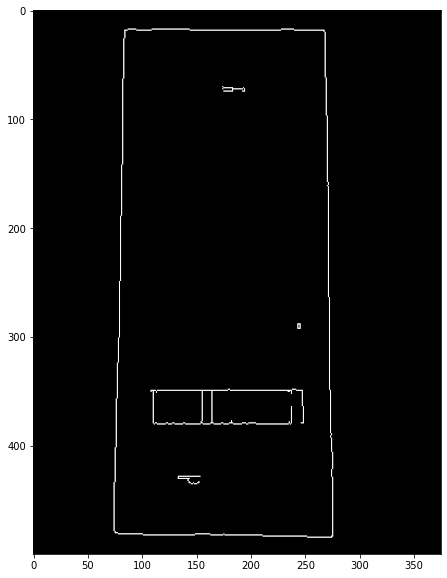

In [ ]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

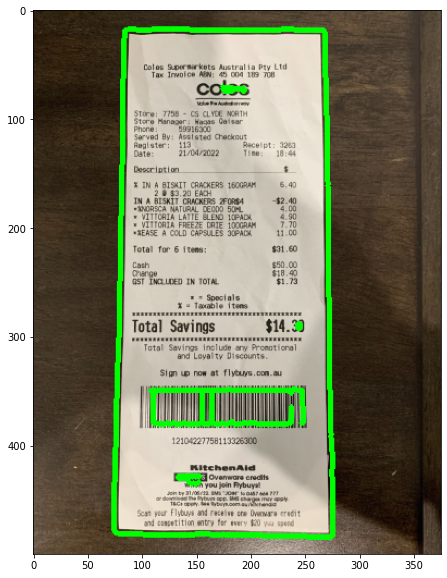

In [ ]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

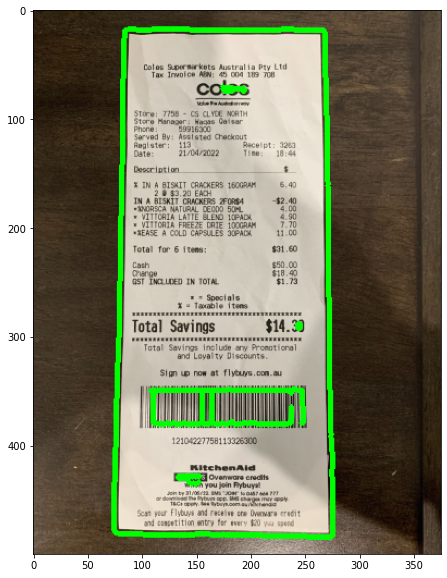

In [ ]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [ ]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [ ]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [ ]:
get_receipt_contour(largest_contours)

array([[[ 84,  18]],

       [[ 74, 478]],

       [[274, 484]],

       [[268,  20]]], dtype=int32)

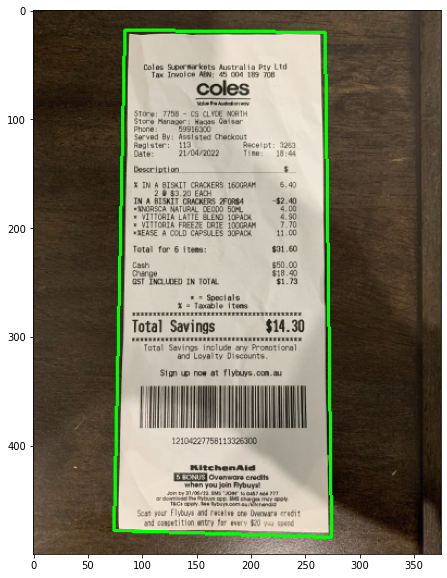

In [ ]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [ ]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [ ]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

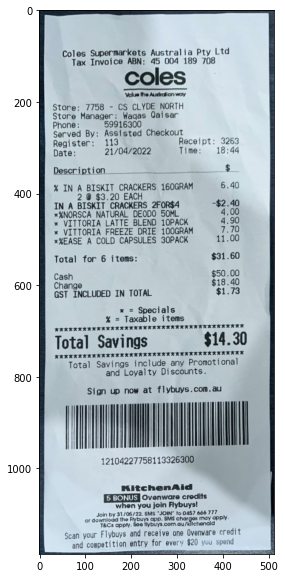

In [ ]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [ ]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

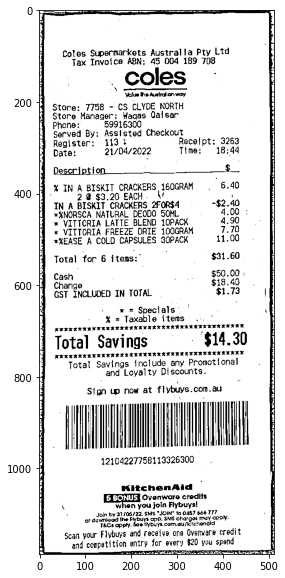

In [ ]:
result = bw_scanner(scanned)
image = bw_scanner(scanned)
plot_gray(result)

In [ ]:
output = Image.fromarray(result)
output.save('result.png')

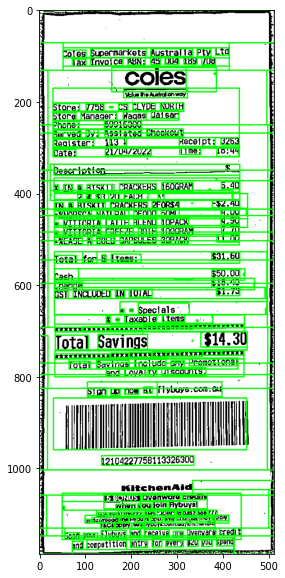

In [ ]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [ ]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

     
        
        
   
      
       
   
      
       
       
   
      
        
      

Coles Supermarkets Australia Pty Ltd
Tax Invoice ABN: 45 004 189 708

_coles ~

PleeReaaricianway
Store: 7758 - CS CLYDE NORTH
Store Manager: Wagas Qaisar
Phone: 59916300
Served By: Assisted Checkout
Register: 1133 Receipt: 3263
Date: 21/04/2022 Time: 18:44

Description SC
% IN A BISKIT CRACKERS, 160GRAM . | 6.40
: @ $3.20 EACH. ¥ ‘

2 @ $3,
IN A BISKIT CRACKERS 2FORS4 ~ ~$2.40
*$NORSCA NATURAL DEODO SOML 4,00 :
x» VITTORIA LATTE BLEND 10PACK 4.90

x» VITTORIA FREEZE DRIE i00GRAM 7.70
*XEASE A COLD CAPSULES SOPACK 11.00

Total for 6 itens:” $31.60
Cash” | $60.00 +
Change ‘ $18.40.
GST INCLUDED IN TOTAL $1.73 | |
* = Specials.‘ , i

% = Taxable items .. ¢
RRR RIRII ARIANA IEE I IE II ITE IIIT ITT THI

Total Savings - “$14.30

ARRIETA IIT RIE REI ORI IARI TTI IIIT
Total Savings include any Promot{onal
and Loyal ty Discounts.

Sign up now at flybuys.com.as

‘OO

12104227758113326300

 
 

Es 

In [ ]:
#extracting grand total
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

In [ ]:
amounts = find_amounts(extracted_text)
amounts

[6.4, 3.2, 2.4, 4.9, 7.7, 11.0, 31.6, 60.0, 18.4, 1.73, 14.3]

In [ ]:
max(amounts)

60.0

In [ ]:
#Lines to excluse on the receipt
exclusion_list = ["bank", "total", "promo", "vat", "change", "recyclable"]

#Words to ommit
remove_list = ["vit", "etc"]

In [ ]:
#Extract letters and numbers regex
regex_line = []
for line in extracted_text.splitlines():
    if re.search(r"[0-9]*\.[0-9]|[0-9]*\,[0-9]", line):
        regex_line.append(line)
print(regex_line)

['% IN A BISKIT CRACKERS, 160GRAM . | 6.40', ': @ $3.20 EACH. ¥ ‘', 'IN A BISKIT CRACKERS 2FORS4 ~ ~$2.40', '*$NORSCA NATURAL DEODO SOML 4,00 :', 'x» VITTORIA LATTE BLEND 10PACK 4.90', 'x» VITTORIA FREEZE DRIE i00GRAM 7.70', '*XEASE A COLD CAPSULES SOPACK 11.00', 'Total for 6 itens:” $31.60', 'Cash” | $60.00 +', 'Change ‘ $18.40.', 'GST INCLUDED IN TOTAL $1.73 | |', 'Total Savings - “$14.30']


In [ ]:
#Apply exclusion list
food_item = []
for eachLine in regex_line:
    found = False
    for exclude in exclusion_list:
        if exclude in eachLine.lower():
            found = True
        
    if found == False:
        food_item.append(eachLine)
print(food_item)

['% IN A BISKIT CRACKERS, 160GRAM . | 6.40', ': @ $3.20 EACH. ¥ ‘', 'IN A BISKIT CRACKERS 2FORS4 ~ ~$2.40', '*$NORSCA NATURAL DEODO SOML 4,00 :', 'x» VITTORIA LATTE BLEND 10PACK 4.90', 'x» VITTORIA FREEZE DRIE i00GRAM 7.70', '*XEASE A COLD CAPSULES SOPACK 11.00', 'Cash” | $60.00 +']


In [ ]:
#Word ommit
new_food_item_list = []
for item in food_item:
    for subToRemove in remove_list:
        item = item.replace(subToRemove, "")
        item = item.replace(subToRemove.upper(), "")
    new_food_item_list.append(item)
print(new_food_item_list)

['% IN A BISKIT CRACKERS, 160GRAM . | 6.40', ': @ $3.20 EACH. ¥ ‘', 'IN A BISKIT CRACKERS 2FORS4 ~ ~$2.40', '*$NORSCA NATURAL DEODO SOML 4,00 :', 'x» TORIA LATTE BLEND 10PACK 4.90', 'x» TORIA FREEZE DRIE i00GRAM 7.70', '*XEASE A COLD CAPSULES SOPACK 11.00', 'Cash” | $60.00 +']


In [ ]:
#Food item cost regex
food_item_cost = []
for line in new_food_item_list:
    line = line.replace(",", ".")
    cost = re.findall('\d*\.?\d+|\d*\,?\d+|',line)
    
    for possibleCost in cost:
        if "." in possibleCost:
            food_item_cost.append(possibleCost)
print(new_food_item_list)

['% IN A BISKIT CRACKERS, 160GRAM . | 6.40', ': @ $3.20 EACH. ¥ ‘', 'IN A BISKIT CRACKERS 2FORS4 ~ ~$2.40', '*$NORSCA NATURAL DEODO SOML 4,00 :', 'x» TORIA LATTE BLEND 10PACK 4.90', 'x» TORIA FREEZE DRIE i00GRAM 7.70', '*XEASE A COLD CAPSULES SOPACK 11.00', 'Cash” | $60.00 +']


In [ ]:
#Remove cost price from food item
count = 0;
only_food_items = []
for item in new_food_item_list:
    only_alpha = ""
    for char in item:
        if char.isalpha() or char.isspace():
            only_alpha += char
            
    only_alpha = re.sub(r'(?:^| )\w(?:$| )', ' ', only_alpha).strip()
    only_food_items.append(only_alpha)
print(only_food_items)

['IN BISKIT CRACKERS GRAM', 'EACH', 'IN BISKIT CRACKERS FORS', 'NORSCA NATURAL DEODO SOML', 'TORIA LATTE BLEND PACK', 'TORIA FREEZE DRIE iGRAM', 'XEASE COLD CAPSULES SOPACK', 'Cash']


In [ ]:
#Removes 2 letter words from food item
#No core food item has two letters (Most cases)
food = []
for item in only_food_items:
    # getting splits
    temp = item.split()

    # omitting K lengths
    res = [ele for ele in temp if len(ele) != 2]

    # joining result
    res = ' '.join(res)
    
    food.append(res)
print(food)

['BISKIT CRACKERS GRAM', 'EACH', 'BISKIT CRACKERS FORS', 'NORSCA NATURAL DEODO SOML', 'TORIA LATTE BLEND PACK', 'TORIA FREEZE DRIE iGRAM', 'XEASE COLD CAPSULES SOPACK', 'Cash']


In [ ]:
food[0]

'BISKIT CRACKERS GRAM'

In [ ]:
#Taulate Food Item and Cost
t = PrettyTable(['Food Item', 'Cost'])
for counter in range (0,len(food)):
    t.add_row([food[counter], food_item_cost[counter]])
print(t)

+----------------------------+-------+
|         Food Item          |  Cost |
+----------------------------+-------+
|    BISKIT CRACKERS GRAM    |  6.40 |
|            EACH            |  3.20 |
|    BISKIT CRACKERS FORS    |  2.40 |
| NORSCA NATURAL DEODO SOML  |  4.00 |
|   TORIA LATTE BLEND PACK   |  4.90 |
|  TORIA FREEZE DRIE iGRAM   |  7.70 |
| XEASE COLD CAPSULES SOPACK | 11.00 |
|            Cash            | 60.00 |
+----------------------------+-------+


In [ ]:
food

['BISKIT CRACKERS GRAM',
 'EACH',
 'BISKIT CRACKERS FORS',
 'NORSCA NATURAL DEODO SOML',
 'TORIA LATTE BLEND PACK',
 'TORIA FREEZE DRIE iGRAM',
 'XEASE COLD CAPSULES SOPACK',
 'Cash']

In [ ]:
import pandas as pd

In [ ]:
data_dict = dict(zip(food, food_item_cost))
data_items = data_dict.items()
data_list = list(data_items)
df = pd.DataFrame(data_list, columns = ['Food', 'Cost'])

In [ ]:
df

,Food,Cost
0,BISKIT CRACKERS GRAM,6.40
1,EACH,3.20
2,BISKIT CRACKERS FORS,2.40
3,NORSCA NATURAL DEODO SOML,4.00
4,TORIA LATTE BLEND PACK,4.90
5,TORIA FREEZE DRIE iGRAM,7.70
6,XEASE COLD CAPSULES SOPACK,11.00
7,Cash,60.00


In [ ]:
mycursor = mydb.cursor()

In [ ]:
sql = "INSERT INTO items (shopid, name, price, sale, discountend, category, discountprice, discountpercentage) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"
val = [(1, food[2], food_item_cost[2], 0, "12/05/22", "Null", 0, 0),
  (1, food[3],food_item_cost[3], 0, "19/05/22", "Null", 0, 0), 
  (1, food[4], food_item_cost[4], 0, "19/05/22", "Null", 0, 0),
  (1, food[5], food_item_cost[5], 0, "19/05/22", "Null", 0, 0),
  (1, food[6], food_item_cost[6], 0, "19/05/22", "Null", 0, 0)]

mycursor.executemany(sql, val)

mydb.commit()

print(mycursor.rowcount, "results inserted.")

5 results inserted.
